<a href="https://colab.research.google.com/github/teamsimcoemmai/mmai894/blob/894-GavinLei/Final%20Project/ResNet50_FastAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The experiment inspired by Sean Sungil Kim's work:  
https://github.com/kimx3314/Stanford-Cars-Dataset-Vehicle-Recognition

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from fastai.vision import *
from fastai.metrics import error_rate
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from glob import iglob
from IPython.core.display import Image, display
import cv2
import time
from fastai.callbacks import *

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = ImageDataBunch.from_folder('/content/drive/MyDrive/Simcoe/894/Car dataset/new','train_set','val_set','test_set',
                                  ds_tfms=get_transforms(do_flip=False, 
                                                         flip_vert=True, 
                                                         p_affine=0.75, # Default value
                                                         max_rotate=5.0, 
                                                         max_zoom=1.1,
                                                         max_warp=0.2,
                                                         p_lighting=0.75, # Defalut value 
                                                         max_lighting=0.2,                                                                                                                  ),
                                                         size=224,
                                                         bs=32).normalize(imagenet_stats)
                                                  
data_test = ImageDataBunch.from_folder('/content/drive/MyDrive/Simcoe/894/Car dataset/new',train='train_set',valid='test_set',
                                  ds_tfms=get_transforms(do_flip=False, 
                                                         flip_vert=True, 
                                                         p_affine=0.75, # Default value
                                                         max_rotate=5.0, 
                                                         max_zoom=1.1,
                                                         max_warp=0.2,
                                                         p_lighting=0.75, # Defalut value 
                                                         max_lighting=0.2,                                                                                                                  ),
                                                         size=224,
                                                         bs=32).normalize(imagenet_stats)
                                                  



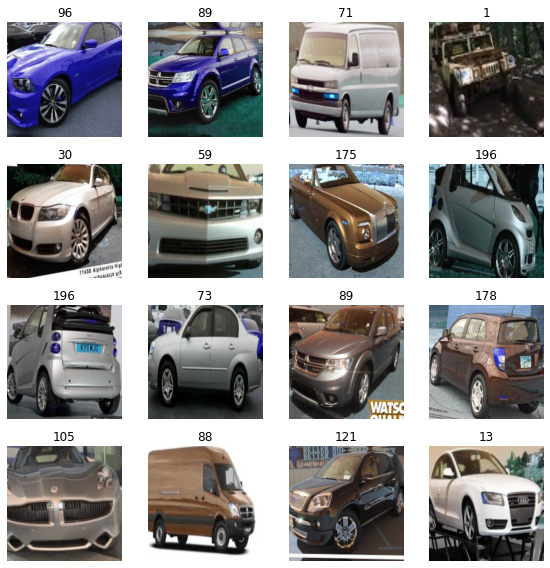

In [5]:
# preview of training data generated from ImageDataBunch
data.show_batch(rows = 4, figsize = (8, 8))

In [6]:

# loading the pre-trained ResNet50 cnn
learn = cnn_learner(data, models.resnet50, pretrained = True, metrics = accuracy,\
                    callback_fns = ShowGraph, model_dir = "/content/drive/MyDrive/894GroupProject/")
# learn.fit_one_cycle(15,
#                     callbacks = [EarlyStoppingCallback(learn,
#                                                       min_delta = 0.01,
#                                                       monitor = 'accuracy',
#                                                       patience = 2)                                               
#                                 ]
#                     )


# learn.summary()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.

Total wd and lr analysis runtime: 1260.6598913669586


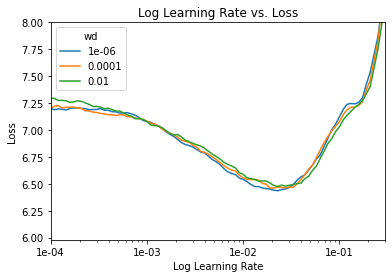

In [7]:
lr_List = []
loss_List = []
wd_List = [1e-6, 1e-4, 1e-2]

start_ts = time.time()
for wd in wd_List:
    exp_learn = cnn_learner(data, models.resnet50, pretrained = True, metrics = accuracy,\
                            model_dir = "/tmp/exp/model/")
    exp_learn.lr_find(wd = wd, num_it = 200)
    lr_List.append(exp_learn.recorder.lrs)
    loss_List.append(exp_learn.recorder.losses)

min_y = 6
max_y = 8
_, ax = plt.subplots(1, 1)
for i in range(len(loss_List)):
    ax.plot(lr_List[i], loss_List[i])
    min_y = min(np.asarray(loss_List[i]).min(), min_y)
ax.set_title('Log Learning Rate vs. Loss'), ax.set_ylabel('Loss'), ax.set_xlabel('Log Learning Rate')
ax.set_xscale('log'), ax.set_xlim((1e-4,3e-1)), ax.set_ylim((min_y - 0.02,max_y))
ax.legend(wd_List, title = 'wd'), ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
print("\nTotal wd and lr analysis runtime:", time.time() - start_ts)
#display(Image(filename = 'outputs/ResNet50/lrfinder1.png'))

epoch,train_loss,valid_loss,accuracy,time
0,3.214000,2.216604,0.450577,09:47
1,2.912779,2.531120,0.390445,01:03
2,2.109720,2.014633,0.479819,01:04
3,1.659008,1.449272,0.601730,01:03
4,1.329471,1.251647,0.666804,01:03
5,1.028871,0.843045,0.763591,01:03
6,0.735610,0.613828,0.820840,01:03
7,0.463579,0.503213,0.846787,01:03
8,0.348668,0.438327,0.873147,01:03
9,0.304457,0.422848,0.878501,01:03


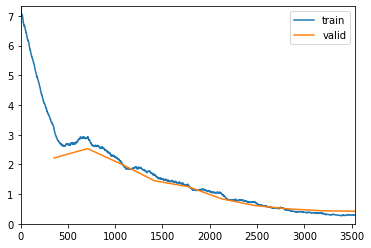

PosixPath('/content/drive/MyDrive/894GroupProject/ResNet50_phase1.pth')

In [8]:
learn.fit_one_cycle(10, max_lr = 1e-2, wd = 1e-2)
learn.save('/content/drive/MyDrive/894GroupProject/ResNet50_phase1', return_path = True)
#display(Image(filename = 'outputs/ResNet50/toplayer output1.png'))

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


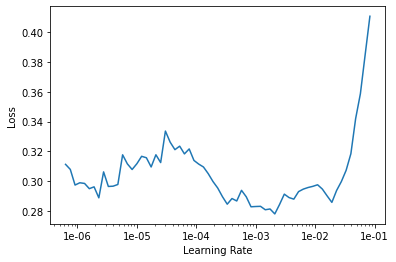

In [9]:
learn.lr_find(wd = 1e-2)
learn.recorder.plot()
#display(Image(filename = 'outputs/ResNet50/lrfinder2.png'))

epoch,train_loss,valid_loss,accuracy,time
0,0.316501,0.421874,0.878913,01:05
1,0.392230,0.473459,0.855848,01:05
2,0.415553,0.499122,0.849671,01:06
3,0.395801,0.461816,0.865733,01:06
4,0.302607,0.413159,0.885502,01:05
5,0.229352,0.389729,0.886326,01:05
6,0.196398,0.341527,0.897858,01:04
7,0.146968,0.341643,0.901977,01:05
8,0.115944,0.332434,0.902801,01:04
9,0.101330,0.332592,0.902389,01:04


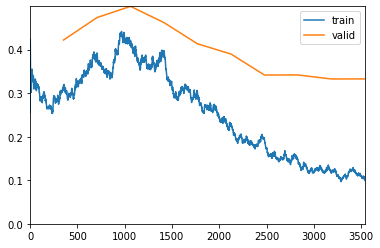

PosixPath('/content/drive/MyDrive/894GroupProject/ResNet50_phase2.pth')

In [10]:
learn = learn.load('/content/drive/MyDrive/894GroupProject/ResNet50_phase1')
learn.unfreeze()
learn.fit_one_cycle(10, max_lr = slice(2e-5, 2e-4), wd = 1e-2)
learn.save('/content/drive/MyDrive/894GroupProject/ResNet50_phase2', return_path = True)
#display(Image(filename = 'outputs/ResNet50/hypertuned output1.png'))

In [11]:
learn1 = learn.load('/content/drive/MyDrive/894GroupProject/ResNet50_phase1')
val_preds1, val_targets1 = learn1.get_preds()
preds1 = val_preds1.tolist()
cls_preds1 = np.array([pred1.index(max(pred1))for pred1 in preds1])
precision1, recall1, fscore1, support1 = precision_recall_fscore_support(np.array(val_targets1), cls_preds1, average = 'weighted')
print('The precision score is', precision1, '\nThe recall score is', recall1, '\nThe fscore score is', fscore1)

The precision score is 0.8859349747453471 
The recall score is 0.878500823723229 
The fscore score is 0.8771827066008074


In [ ]:
len(preds1)

In [12]:
learn2 = learn.load('/content/drive/MyDrive/894GroupProject/ResNet50_phase2')
val_preds2, val_targets2 = learn2.get_preds()
preds2 = val_preds2.tolist()
cls_preds2 = np.array([pred2.index(max(pred2))for pred2 in preds2])
precision2, recall2, fscore2, support2 = precision_recall_fscore_support(np.array(val_targets2), cls_preds2, average = 'weighted')
print('The precision score is', precision2, '\nThe recall score is', recall2, '\nThe fscore score is', fscore2)

The precision score is 0.9112357229528192 
The recall score is 0.9023887973640856 
The fscore score is 0.9018816433373528


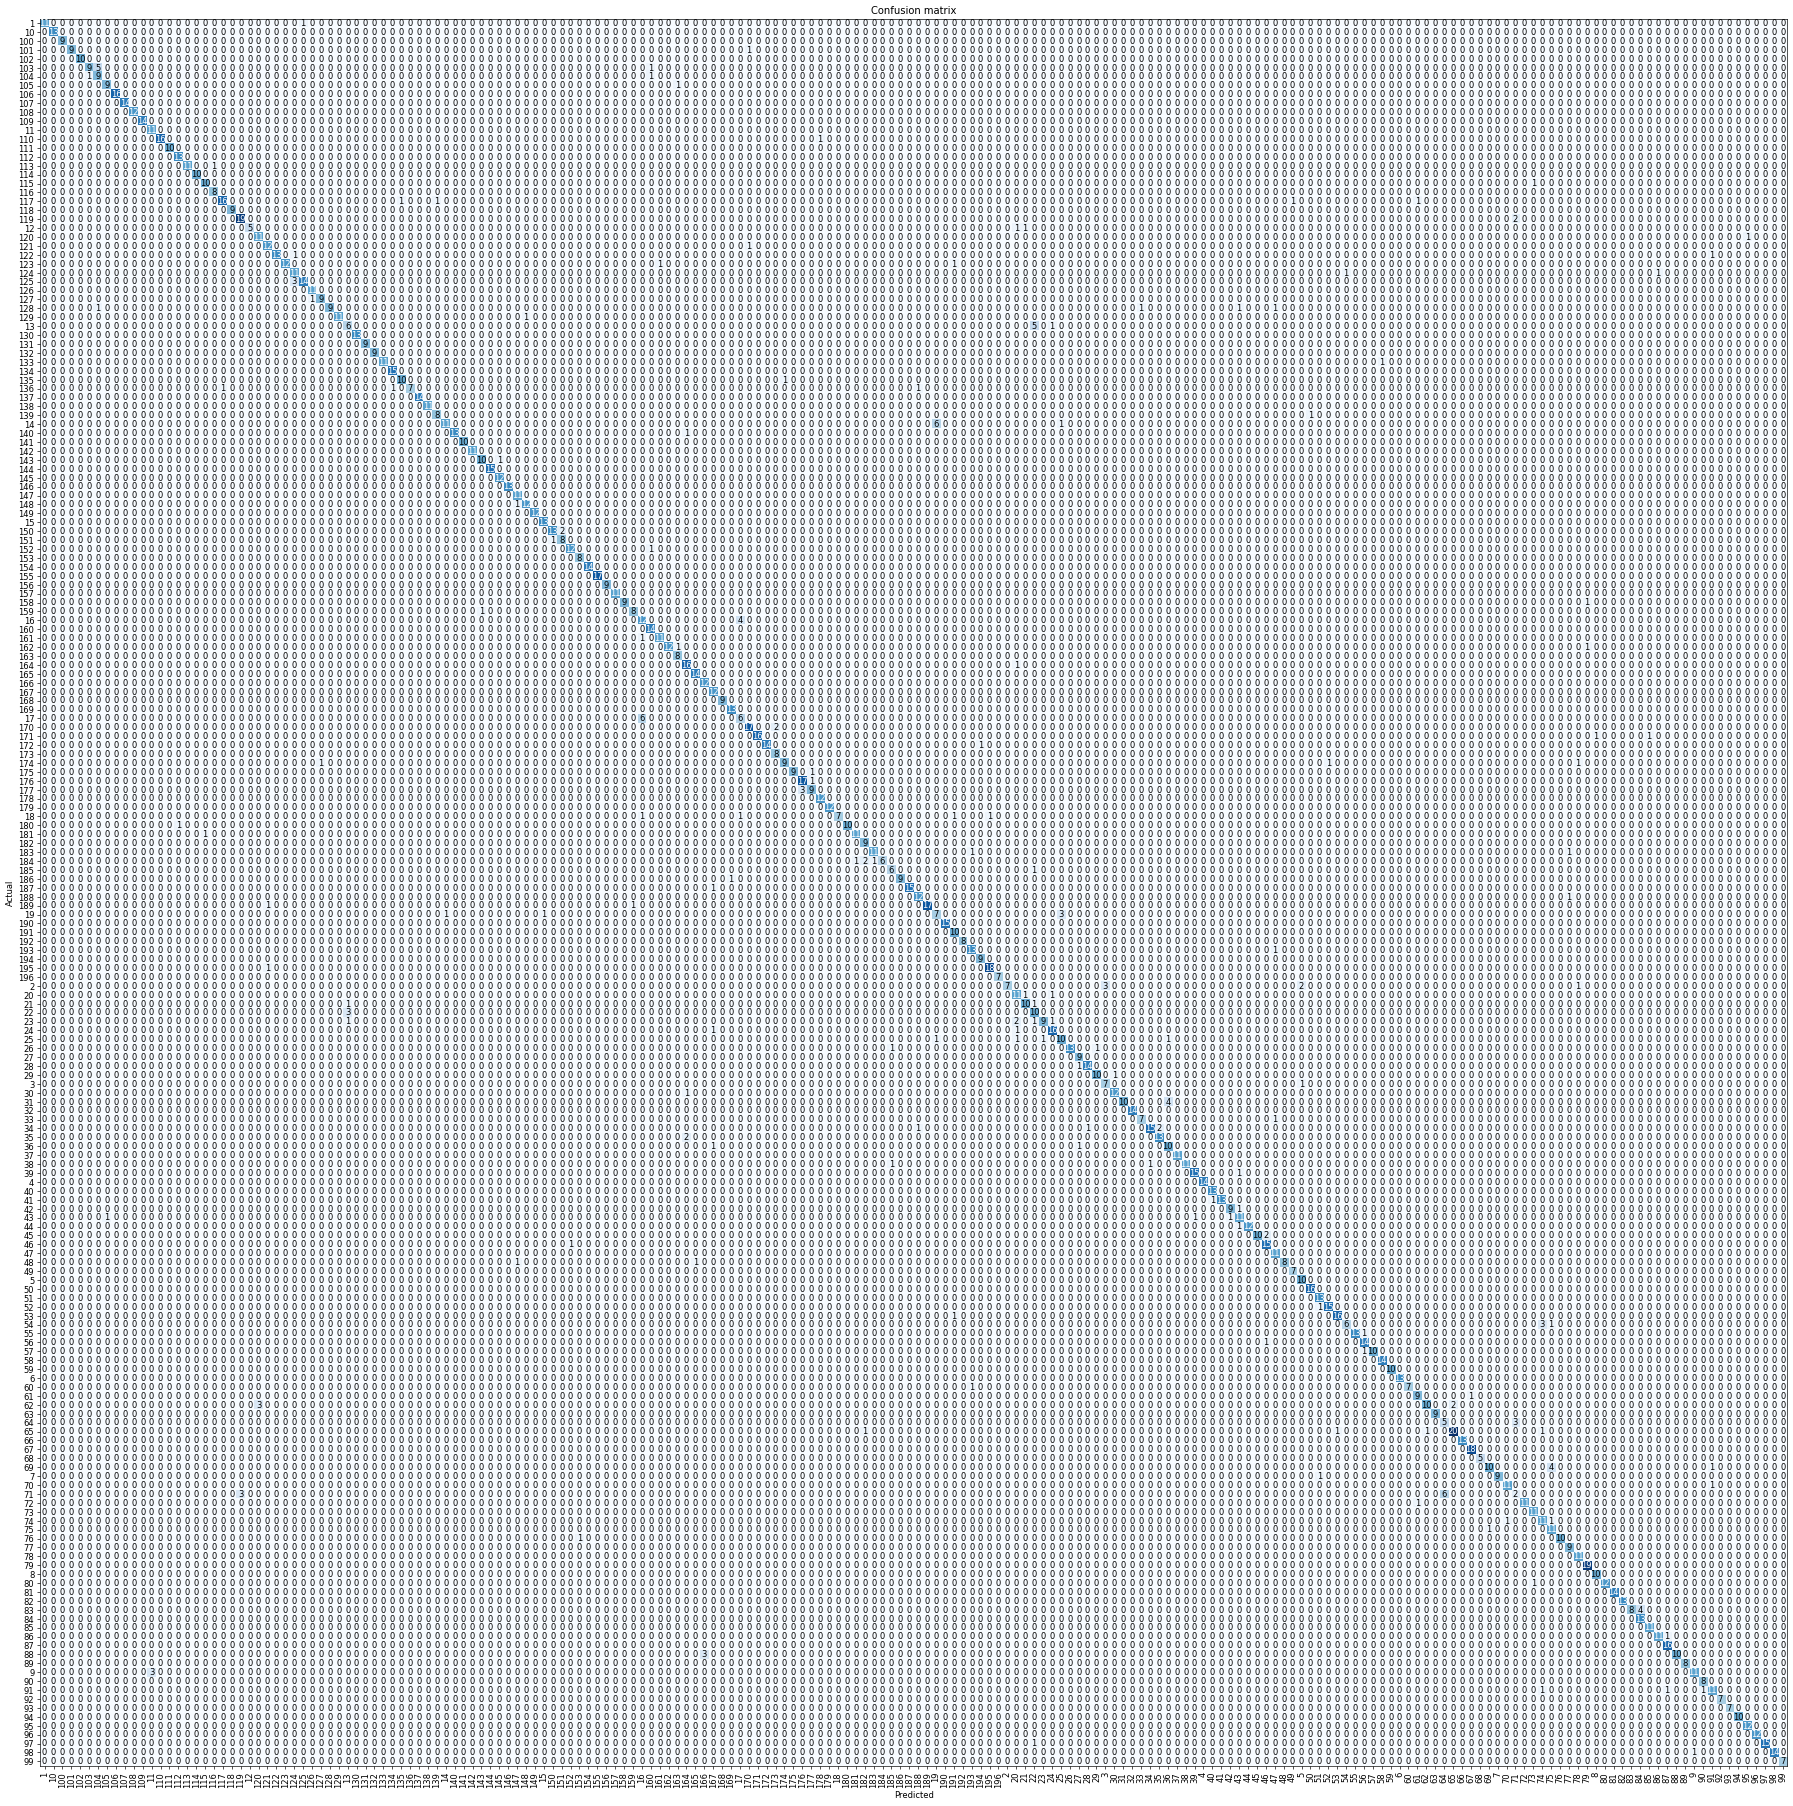

In [13]:
interp2 = ClassificationInterpretation.from_learner(learn2)
interp2.plot_confusion_matrix(figsize = (30, 30), dpi = 60)

In [14]:
# losses, idxs = interp.top_losses()
interp2.most_confused(min_val = 6)

[('14', '19', 6), ('17', '16', 6), ('71', '64', 6)]

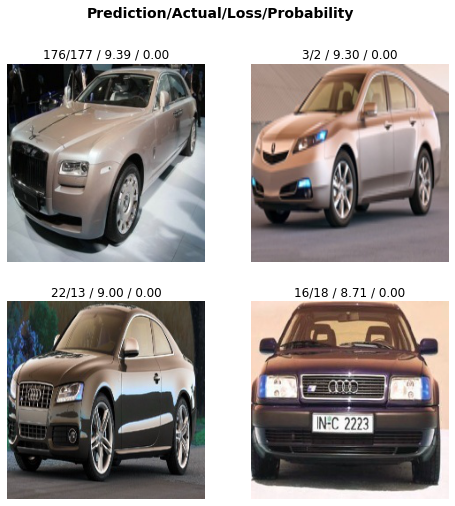

In [15]:
interp2.plot_top_losses(4, figsize = (8, 8))

In [32]:
from tqdm import tqdm

In [34]:
#Evaluation
preds = []
dataIndex = []
num_preds = 2427
for i in tqdm(range(num_preds)):
    p = learn.predict(data.test_ds.x[i])
    preds.append(str(p[0]))
    dataIndex.append(str(learn.data.test_ds.items[i]).split('/')[-1])

dataIndex1 = np.asarray(dataIndex)
preds = list(map(int, preds))
pred_tup = list(zip(dataIndex1,preds))
pred_tup.sort()


df_test_new = pd.read_csv('/content/drive/MyDrive/Simcoe/894/Car dataset/df_test_new.csv')
actual_tup = df_test_new[['img_name','class']].to_records(index=False)
actual_tup = list(actual_tup)

df_pred = pd.DataFrame(pred_tup,columns=['img_name','pred_class'])
df_valid = df_test_new.merge(df_pred, left_on='img_name', right_on='img_name')

feature_list1 = ['img_name','class','pred_class']
df_valid1 = df_valid[feature_list1]

df_valid1['diff'] = np.where(df_valid1['class'] == df_valid1['pred_class'],1,0)
accuracy = df_valid1['diff'].sum()/df_valid1.shape[0]
accuracy


precision, recall, fscore, support = precision_recall_fscore_support(df_valid1['class'].values, df_valid1['pred_class'].values, average = 'weighted')
print('The precision score is', precision, '\nThe recall score is', recall, '\nThe fscore score is', fscore, '\nThe accuract score is', accuracy)

100%|██████████| 2427/2427 [00:31<00:00, 76.84it/s]


The precision score is 0.9103452168521641 
The recall score is 0.9019365471775855 
The fscore score is 0.901664825936507 
The accuract score is 0.9019365471775855


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# # misclassified images
# for i in range(len(test_targets)):
#     if test_targets[i] != test_cls_preds[i]:
#         print(data.classes[test_targets[i]], 'was misclassified as', data.classes[test_cls_preds[i]])